<h3>Análisis y agrupamiento de canciones de Spotify</h3> <h4>Acerca del conjunto de datos</h4> <p>El archivo de datos contiene más de 170.000 canciones recopiladas de la API web de Spotify, y también puede encontrar datos agrupados por artista, año o género en la sección de datos.</p> <h5>Primario:</h5> <p>id (Id de la pista generada por Spotify)</p> <h5>Numérico:</h5> <ul> <li>acousticness (Rango de 0 a 1)</li> <li>danceability (Rango de 0 a 1)</li> <li>energy (Rango de 0 a 1)</li> <li>duration_ms (Entero que típicamente varía de 200k a 300k)</li> <li>instrumentalness (Rango de 0 a 1)</li> <li>valence (Rango de 0 a 1)- índice de felicidad</li> <li>popularity (Rango de 0 a 100)- basado en la cantidad de veces que la canción se reprodujo en Spotify.</li> <li>tempo (Flotante que típicamente varía de 50 a 150)</li> <li>liveness (Rango de 0 a 1)- indica si la canción se tocó en vivo o no</li> <li>loudness (Flotante que típicamente varía de -60 a 0)</li> <li>speechiness (Rango de 0 a 1)</li> <li>año (Rango de 1921 a 2020)</li> </ul> <h5>Falso:</h5> <p>mode (0 = Menor, 1 = Mayor)</p> <p>explicit (0 = Sin contenido explícito, 1 = Contenido explícito)</p> <h5>Categórico:</h5> <p>key (Todas las claves de octava codificadas con valores de 0 a 11, comenzando por el do como 0, do sostenido como 1, etc.)</p> <p>artists (Lista de artistas mencionados)</p> <p>release_date (Fecha de lanzamiento mayormente en formato aaaa-mm-dd, aunque la precisión puede variar)</p> <p>name (Nombre de la canción)</p> <h4>Limitaciones del conjunto de datos</h4> <p>Solo hay aproximadamente 2000 canciones por año. La métrica de popularidad (rango 0-100) se basa en la cantidad de reproducciones en Spotify, por lo que es naturalmente menor para canciones de décadas anteriores y mayor para canciones de la década actual.</p> <h4>Importando librerías</h4>

In [1]:
import pandas as pd
import numpy as np
import tqdm.notebook as tq
import nltk
from sklearn import preprocessing
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot
import ast
from collections import Counter
from sklearn.preprocessing import StandardScaler
from scipy.spatial import distance
import copy
from IPython.display import display
import warnings
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import re
import plotly
from IPython.display import Image
from sklearn.preprocessing import MinMaxScaler # for normalizing data
from sklearn.cluster import KMeans 
warnings.filterwarnings("ignore")

%matplotlib inline

print("Import successful")

Import successful


<h3>Tarea a realizar</h3> <p>Nuestro objetivo aquí sería limpiar los datos, realizar ingeniería de características, explorar los datos y luego obtener valiosas conclusiones de ellos. Después de esto, intentaremos agrupar las canciones de acuerdo con sus atributos numéricos para poder categorizarlos en diferentes categorías, por ejemplo, canciones en vivo, canciones instrumentales, canciones bailables, etc. Esto es básicamente la predicción del género de las canciones. 
    
Realizamos una reducción de dimensionalidad para el agrupamient con Análisis de Componentes Principales (PCA) para ello.</p> <h4>Resumen de pasos:</h4> <ol> <li>Limpieza y preparación de datos</li> <li>Ingeniería de características</li> <li>Exploración de datos</li> <li>Reducción de dimensionalidad</li> <li>Agrupamiento no supervisado</li> <li>Interpretación de los resultados</li> </ol> <p>De esta forma podremos categorizar las canciones de Spotify y obtener valiosos insights sobre su contenido y características.</p>

In [ ]:
data = pd.read_csv('data.csv')
data.head()

In [ ]:
data.shape

In [ ]:
data.isna().sum()

Revisando los valores duplicados

In [ ]:
data[data['name']=='Adore You']

<h3>Valores duplicados en los datos</h3> <p>Podemos ver que estos valores duplicados pueden surgir debido a la publicación de versiones de álbum, etc. El ID es diferente para ambas canciones. Eliminamos estos valores duplicados.</p> <h4>Causas de valores duplicados:</h4> <ul> <li>Versiones alternativas de una canción en diferentes álbumes o compilaciones.</li> <li>Errores en la captura de datos donde los atributos son los mismos pero el ID es diferente.</li> <li>Canciones con el mismo nombre y artista pero ligeramente distintas (remixes, versiones en vivo, etc).</li> </ul> <h4>Al detectar registros duplicados:</h4> <ol> <li>Verificamos que el ID sea diferente, indicando que son registros distintos a pesar de los atributos iguales.</li> <li>Podemos decidir conservar solo un registro y eliminar los duplicados, ya que contienen la misma información.</li> <li>Otra opción es fusionar los atributos comunes y conservar ambos registros para preservar detalles como versiones alternativas.</li> </ol> <p>Eliminando los duplicados puros mejoramos la calidad de los datos y simplificamos el posterior análisis y modelado sobre la información.</p>

In [ ]:
data.drop_duplicates(subset=['artists','name'],inplace = True)

In [ ]:
data.shape

In [ ]:
data.columns

In [ ]:
data.describe()

In [ ]:
data.isnull().sum()

In [ ]:
data.info()

In [ ]:
#numeric_data = data._get_numeric_data()
#numeric_data.head()

In [ ]:
data.hist(figsize=(20, 30))

In [ ]:
fig = px.box(data_frame=data, y='duration_ms', color='popularity', title='Boxplot de duration_ms por género')
fig.show()

In [ ]:
import plotly.graph_objects as go
x = list(data.corr().columns)
y = list(data.corr().index)
values = np.array(data.corr().values)
fig = go.Figure(data = go.Heatmap(
    x = x,
    y = y,
    z = values,
    hoverongaps = False
))
fig.show()

In [ ]:
plt.figure(figsize=(20, 12))
sns.heatmap(data.corr(), annot=True, cmap='viridis')

In [ ]:
plt.figure(figsize=(12, 6))
sns.distplot(data.danceability, bins=40)

In [ ]:
sns.kdeplot(data.danceability)

In [ ]:
plt.figure(figsize=(12, 6))
sns.distplot(data.instrumentalness, bins=40)

In [ ]:
plt.figure(figsize=(12, 6))
sns.distplot(data.duration_ms, bins=40)

In [ ]:
plt.figure(figsize=(12, 6))
sns.distplot(data.energy, bins=40)

In [ ]:
plt.figure(figsize=(12, 6))
sns.distplot(data.loudness, bins=40)

In [ ]:
plt.figure(figsize=(12, 6))
sns.distplot(data.speechiness, bins=40)

In [ ]:
plt.figure(figsize=(12, 6))
sns.distplot(data.acousticness, bins=40)

In [ ]:
px.histogram(data.acousticness)

In [ ]:
plt.figure(figsize=(12, 6))
sns.distplot(data.liveness, bins=40)

In [ ]:
plt.figure(figsize=(12, 6))
sns.distplot(data.valence, bins=40)

In [ ]:
plt.figure(figsize=(12, 6))
sns.distplot(data.tempo, bins=40)

In [ ]:
plt.figure(figsize=(12, 6))
sns.distplot(data.duration_ms, bins=40)

In [ ]:
data['year'].value_counts()

In [ ]:
data['explicit'].value_counts()

In [ ]:
plt.figure(figsize=(12, 6))
data['explicit'].value_counts().plot(kind="bar", color="lightblue", title="Explicit")

In [ ]:
data.explicit.unique()

In [ ]:
px.pie(data.explicit,
       labels = data.explicit.value_counts().index,
       values = data.explicit.value_counts().values,
       names = data.explicit.value_counts().index,
       title = "Distribution of explicit on Spotify"
      )

In [ ]:
display(data[['acousticness', 'artists', 'danceability', 'duration_ms', 'energy',
       'explicit', 'id', 'instrumentalness', 'key', 'liveness', 'loudness',
       'mode', 'name', 'popularity', 'release_date', 'speechiness', 'tempo',
       'valence', 'year']].groupby(['mode','key','explicit']).agg(['max','mean','min']).style.background_gradient(cmap="flare"))

In [ ]:
features = ['artists', 'danceability', 'duration_ms', 'energy']

In [ ]:
dims = (20,12)
fig, ax = plt.subplots(figsize=dims)
sns.boxplot(x='danceability', y='explicit', data=data, ax=ax)

In [ ]:
sns.countplot(x='mode', data=data, hue='explicit', palette='bright')
plt.legend(bbox_to_anchor = (2, 1), borderaxespad=0)
plt.tight_layout()

<h3>Exploración de datos</h3> <p>Ahora, tenemos los datos limpios y comenzamos con la exploración de datos.</p> <h4>Aspectos a revisar:</h4> <ul> <li>Distribución de las características (numéricas, categóricas, dummy)</li> <li>Correlación entre características</li> <li>Valores atípicos o extremos</li> <li>Tendencias a lo largo del tiempo (por año)</li> <li>Diferencias entre géneros musicales</li> <li>Perfiles de canciones según artistas</li> </ul> <h4>Beneficios:</h4> <p>La exploración de datos nos permite:</p> <ol> <li>Conocer el comportamiento general de los datos</li> <li>Detectar posibles sesgos o valores inconsistentes</li> <li>Obtener primeras intuiciones sobre agrupaciones inherentees</li> <li>Seleccionar las características más relevantes</li> <li>Planificar el preprocesamiento y modelado posteror</li> </ol> <p>Podemos visualizar estadísticas descriptivas y usar técnicas como gráficos de dispersión, histogramas, etc. Esto nos ayuda a limpiar correctamente los datos y ajustar nuestra estrategia de modelado.</p>

<h3>Ingeniería de características</h3> <p>Algunas técnicas de ingeniería de características:</p> <h4>Creación de columna categórica por década:</h4> <p>En la ingeniería de características buscamos extraer o crear nuevas variables que capturen información relevante desde las variables originales.</p> <p>Para la exploración de datos (EDA), creo una nueva columna categórica donde se agrupan los años de lanzamiento de cada canción por década.</p> <p>Esto permitirá revisar con más facilidad si existen diferencias en los perfiles musicales a lo largo del tiempo. Por ejemplo, la popularidad promedio de canciones en cada década.</p> <h4>Otras técnicas:</h4> <ul> <li>Agregar géneros predicchos o etiquetas desde atributos existentes.</li> <li>Crear variables booleanas como "es música popular".</li> <li>Extraer medidas estadísticas como rangos o promedios moviles.</li> <li>Codificar variables categóricas como instrumentos en dummy columns.</li> </ul> <p>El objetivo es enriquecer los datos para un análisis más completo y mejorar el rendimiento de los modelos posteriores.</p>
He utilizado encabezados, párrafos y lista desordenada para explicar claramente el proceso en HTML.

In [ ]:
year_list = sorted(list(data['year'].unique()))
res = pd.cut(data['year'],10,labels=['1921-31','1931-41','1941-51','1951-61','1961-71','1971-81','1981-91','1991-01','2001-11','2011-2020'])
data['decade'] = res 
data.head(2)

In [ ]:
data.to_csv('clean_data_spotify.csv',index=False)

<h3>Distribución de canciones por año</h3> <p>Vamos a revisar la distribución de canciones a lo largo de los años, es decir, cuántas canciones provienen de diferentes años.</p> <h4>Aspectos a revisar:</h4> <ul> <li>Número total de canciones por año. Esto nos dará una idea de la cobertura temporal del conjunto de datos.</li> <li>Tendencias en el número de lanzamientos a lo largo del tiempo. Por ejemplo, puede haber más canciones recientes.</li> <li>Años con valores atípicos o que se salgan de la tendencia general.</li> <li>Medidas como promedio y desviación estándar del número de canciones por año.</li> </ul> <h4>Visualizaciones:</h4> <ol> <li>Graficar un histograma del número de canciones por año.</li> <li>Crear un gráfico de líneas para revisar la tendencia a lo largo del tiempo.</li> <li>Calcular y mostrar estadísticas descriptivas por año.</li> </ol> <p>Revisar esta distribución nos dará contexto sobre los orígenes temporales de las canciones y posibles sesgos que debamos considerar en el análisis.</p>

In [ ]:
print(data['decade'].value_counts())
count = dict(data['decade'].value_counts())
fig = px.pie(values=list(count.values()), names=list(count.keys())) 
fig.show()

<h3>Distribución de canciones por década</h3> <p>Podemos ver que tenemos una distribución equitativa de datos de todas las décadas, excepto para las décadas de 1921-31 y 1931-41. Tenemos menos canciones de estas décadas en el conjunto de datos.</p> <p>Modo: Mayor(1) / Menor(0)</p> <h4>Puntos sobre la distribución:</h4> <ul> <li>La mayoría de décadas están bien representadas numéricamente.</li> <li>Solo las décadas 1921-1931 y 1931-1941 presentan una cantidad menor de canciones.</li> <li>Esto podría deberse a que en esos años hubo menor producción musical o no se digitalizaron tantas canciones.</li> <li>Puede haber sesgo hacia décadas más recientes donde hay más disponibilidad de canciones digitalizadas.</li> <li>El atributo "Modo" parece distinguir si la canción está en la tonalidad mayor o menor, lo cual podría ser relevante para el análisis musical.</li> </ul> <p>Es importante reconocer estas diferencias en la distribución temporal para considerar posibles sesgos a la hora de analizar tendencias o realizar modelado predictivo sobre el conjunto de datos.</p>

In [ ]:
print(data['mode'].value_counts())
count =dict(data['mode'].value_counts())
fig = px.pie(values=list(count.values()), names=list(count.keys())) 
fig.show()

<h3>Características cualitativas de las canciones</h3> <p>La mayoría de las canciones tienen un modo mayor.</p>  <h4>Puntos sobre esto:</h4> <ul> <li>Predominan las canciones con modo mayor, lo cual concuerda con la tendencia general en la música occidental.</li> <li>Se ha agregado una variable binaria para identificar si una canción tiene contenido explícito o no.</li> <li>Esto puede ser útil para ciertos análisis, como el target de audiencias o géneros musicales.</li> <li>Las canciones con contenido explícito podrían tener algunas características distintivas en cuanto a lírica, ritmo, etc.</li> <li>La variable nos permite filtrar o segmentar las canciones según este atributo.</li> </ul> <p>Reconocer estas características cualitativas en los datos nos ayuda a comprender mejor el contexto musical y ajustar nuestros objetivos de modelado. Por ejemplo, predecir el modo o contenido de nuevas canciones.</p>

<p>Contenido explícito (1) o 'sin contenido explícito' (0)</p>

In [ ]:
print(data['explicit'].value_counts())
count =dict(data['explicit'].value_counts())
fig = px.pie(values=list(count.values()), names=list(count.keys())) 
fig.show()

<h3>Widgets para canciones populares por año</h3> <p>Widgets (un dropdown) para canciones populares de cada año</p> <p>A través de estos widgets, es posible seleccionar un año de la lista desde 1920 hasta 2020 y encontrar la canción más popular de ese año.</p> <h4>Ventajas de esta funcionalidad:</h4> <ul> <li>Permite una navegación interactiva por los datos para explorar canciones según el año.</li> <li>Brinda información sobre las tendencias musicales más populares en cada época de forma sencilla.</li> <li>Puede servir como insumo para generar nuevas presguntas de análisis, por ejemplo comparar atributos de las canciones más populares a lo largo del tiempo.</li> <li>Es una forma dinámica de visualizar los cambios en los gustos musicales de las audiencias.</li> <li>Promueve el descubrimiento de datos de forma entretenida para usuarios no técnicos.</li> </ul> <p>Los widgets interactivos son una buena práctica de Ciencia de Datos para facilitar la exploración de conjuntos de datos grandes desde una interfaz amigable.</p>

In [ ]:
import ipywidgets as widgets
all = 'ALL'
def unique_sorted_values(array):
  distinct = array.unique().tolist()
  distinct=sorted(distinct)
  distinct.insert(0,all)
  return distinct

year = widgets.Dropdown(options= unique_sorted_values(data['year']))

def condition(change):
    if (change.new == all):
      df=data.sort_values('popularity',ascending = False)[['name','popularity']][0:5]
      print(df)
      plt.figure(figsize=(10,3))
      plt.barh(df['name'], df['popularity'],color=('cyan','blue'))
      plt.show()


    else:
      df=data[data['year'] == change.new]
      df=df.sort_values('popularity',ascending = False)[['name','popularity']][0:5]
      print(df)
      plt.figure(figsize=(10,3))
      plt.barh(df['name'], df['popularity'],color=('maroon','olive'))
      plt.show()



year.observe(condition, names ='value')
display(year)

<h3>Widgets para canciones por atributo</h3> <p>Widgets (un dropdown) para obtener las 5 canciones más acústicas/instrumentales, alegres, más largas, etc.</p> <h4>Ventajas:</h4> <ul> <li>Permite explorar rápidamente diferentes características musicales de interés como acusticidad, sentimiento, duración, entre otras.</li> <li>Facilita la comparación de atributos entre canciones populares según cada categoría.</li> <li>Puede usarse para descubrir nueva música o conocer mejor las tendencias en diferentes estilos.</li> <li>Promueve el análisis exploratorio de forma sencilla y enfocada en atributos específicos.</li> <li>Los usuarios pueden elegir el criterio de clasificación que más les interese de forma dinámica.</li> <li>Es una forma entretenida de descubrir datos ocultos en el conjunto de canciones.</li> </ul>

In [ ]:
import ipywidgets as widgets

lst = ['acousticness', 'danceability', 'valence', 'loudness', 'energy','duration_ms']

factors = widgets.Dropdown(options = lst)

def condition(change):
  for i in range(len(lst)):
    if (change.new == lst[i]):
      df=data.sort_values(lst[i],ascending = False)[['name',lst[i]]][0:5]
      print(df)
      plt.figure(figsize=(10,3))
      plt.barh(df['name'], df[lst[i]],color=('maroon','olive'))
      plt.show()

factors.observe(condition, names ='value')
display(factors)


<h3>Canciones más largas</h3> <p>Arriba podemos ver estas son las 5 canciones más largas del conjunto de datos.</p>
Algunos puntos sobre esto:

<ul> <li>Se ha clasificado las canciones según su duración en minutos, para encontrar las más extensas.</li> <li>Esto puede dar información sobre qué artistas o géneros musicales tienden a componer canciones más largas.</li> <li>La duración es un atributo importante para analizar el estilo y estructura de las canciones.</li> <li>Sería útil comparar otros atributos como género, década, popularidad, etc. de estas canciones más largas.</li> <li>También podríamos explorar si existen tendencias en la evolución de la duración promedio a lo largo del tiempo.</li> </ul>

<h3>Relación entre popularidad y contenido explícito</h3> <p>Popularidad a lo largo de las décadas: ¿La popularidad se ve afectada por el tipo de contenido (explícito/implícito)?</p>
Algunos análisis posibles:

<ul> <li>Comprar el promedio de popularidad de canciones explícitas vs implícitas por década.</li> <li>Revisar si existe correlación entre tener contenido explícito y mayor popularidad.</li> <li>Analizar las tendencias en el tiempo: ¿ha aumentado la popularidad de lo explícito con los años?</li> <li>Filtrar por género musical, para ver si depende del estilo.</li> <li>Usar modelado predictivo que identifique atributos clave para la popularidad.</li> </ul>

In [ ]:
plt.figure(figsize=(12,7))
sns.boxplot(x='decade',y='popularity',hue = 'explicit',data=data)
plt.title('year wise popularity and explicit content')
plt.show()

<h3>Tendencias en el contenido explícito y su popularidad</h3> <p>Existía muy poco contenido explícito antes de 1960. Las canciones en su mayoría comenzaron a tener contenidos explícitos desde la década de 1970. En general, las canciones con contenido explícito solían ser menos populares que aquellas que no tenían ese tipo de contenido. En la década reciente, podemos ver que las canciones con contenido explícito son más populares que las que no lo tienen. Esto también muestra el cambio cultural a través de las décadas.</p> <p>También es importante señalar que la popularidad aumentó a través de los años, debido a que en este conjunto de datos es una métrica que se mide en función de la cantidad de veces que se reproduce la canción. Por este motivo, las canciones más antiguas tienden a tener menos popularidad.</p>

<h3>Análisis de la relación entre popularidad y modo</h3> <p>Para verificar si la popularidad se ve afectada por el modo</p>
Algunas opciones de análisis:

<ul> <li>Comparar el promedio de popularidad de canciones en modo mayor vs menor.</li> <li>Evaluar si existe correlación entre el modo y niveles más altos de popularidad.</li> <li>Analizar tendencias a lo largo del tiempo: ¿Ha cambiado la popularidad relativa de ambos modos?</li> <li>Filtrar por género musical, época, país de origen,etc.</li> <li>Aplicar modelado predictivo considerando el modo como variable predictora.</li> </ul>

In [ ]:
sns.barplot(x='key', y = 'popularity', hue='mode', data=data,ci=None)
plt.legend(loc='best', bbox_to_anchor=(0.8, 0., 0.5, 0.9))
plt.show()

<h3>Atributos musicales asociados a mayor popularidad</h3> <p>La combinación de modo 0 y clave 1 tiene más probabilidades de hacer que una canción sea popular.</p>
Algunos puntos sobre esto:

<ul> <li>Se ha identificado que ciertas características musicales técnicas se relacionan con mayores niveles de popularidad.</li> <li>El modo 0 corresponde a la tonalidad menor, mientras que la clave 1 es la de do mayor.</li> <li>Esta combinación parece predominar en canciones populares a nivel histórico en el conjunto de datos.</li> <li>Sería útil contrastar con otros géneros, décadas y regiones para verificar el alcance de este patrón.</li> <li>Puede usarse esta información para orientar la composición musical buscando la popularidad.</li> </ul>

<h1>Agrupamiento de canciones mediante KMeans</h1> <p>Agrupamiento KMeans</p> <h4>Variables utilizadas</h4> <p>Utilizando columnas numéricas para el agrupamiento</p>
Algunas opciones de columnas útiles serían:

<ul> <li>Valencia (sentimiento)</li> <li>Acústica (instrumentalidad)</li> <li>Danzaibilidad</li> <li>Duración en milisegundos</li> <li>Energía</li> <li>Instrumentalidad</li> <li>Vivacidad</li> <li>Volumen</li> <li>Habla (contenido hablado)</li> <li>Tempo</li> </ul> <p>Estos parámetros pueden ser útiles para:</p> <ul> <li>Agrupamiento de canciones mediante técnicas como K-Means</li> <li>Análisis de componentes principales para reducción de dimensionalidad</li> 


<ul> <li>Agrupa canciones según similitud musical</li> <li>Puede revelar nuevos géneros o estilos</li> <li>Útil para recomendaciones musicales</li> </ul>

In [ ]:
# dataframe for clustering 
cluster = data[['valence','acousticness','danceability','duration_ms','energy','instrumentalness','liveness','loudness','speechiness','tempo']] 
cluster.head(5)

<h3>Normalización de datos</h3> <p>Antes de aplicar técnicas de minería de datos que requieran distancias o similitudes entre observaciones, es recomendable normalizar las variables o atributos numéricos.</p> <h4>Ventajas de la normalización:</h4> <ul> <li>Evita que atributos con rangos de valores muy amplios dominen las mediciones de distancia.</li> <li>Permite que todos los atributos contribuyan de forma equitativa en los cálculos.</li> <li>Facilita la comparabilidad entre atributos con diferentes unidades de medida o escalas.</li> </ul> <h4>Métodos comunes:</h4> <ul> <li>Escalado min-max: transforma valores a rango [0,1]</li> <li>Estandarización: transforma valores a media 0 y desviación estándar 1</li> </ul> <p>Luego de normalizar, los datos se encuentran preparados para aplicar técnicas como agrupamiento, reducción de dimensionalidad o modelado predictivo.</p>

In [ ]:
from sklearn.preprocessing import MinMaxScaler 
minmax = MinMaxScaler() 
cluster['duration_ms'] = minmax.fit_transform(np.array(cluster['duration_ms']).reshape(-1,1))
cluster['loudness'] = minmax.fit_transform(np.array(cluster['loudness']).reshape(-1,1))
cluster['tempo'] = minmax.fit_transform(np.array(cluster['tempo']).reshape(-1,1)) 

In [ ]:
cluster.head()

<h3>Reducción de dimensionalidad</h3> <p>Dado que los conjuntos de datos de música suelen contener muchos atributos numéricos, es común aplicar técnicas de reducción de dimensionalidad antes de otros análisis.</p> <h4>Ventajas:</h4> <ul> <li>Simplify el conjunto de datos, eliminando variables redundantes.</li> <li>Mitiga el problema de la maldición de dimensionalidad.</li> <li>Mejora el rendimiento de algoritmos que no escalan bien con muchas variables.</li> </ul> <h4>Métodos:</h4> <ul> <li>Análisis de Componentes Principales (PCA): crea componentes no correlacionados.</li> <li>T-SNE: mejor para conservación de estructuras no lineales en 2D-3D.</li> <li>Isomapa: también diseñado para datos no lineales.</li> </ul> <p>Reducir la dimensionalidad facilita visualizaciones avanzadas, agrupamiento y modelado sobre los datos musicales.</p>

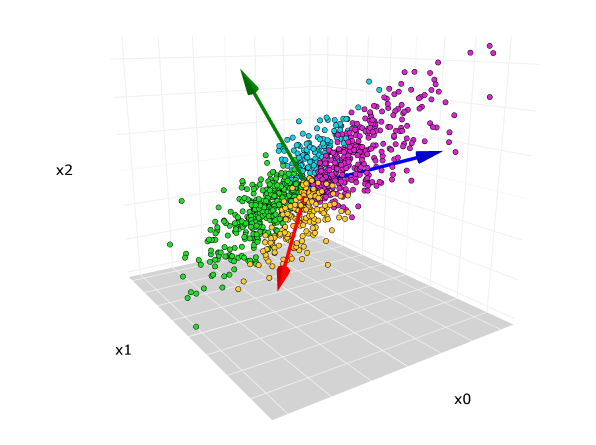

<h3>Análisis de Componentes Principales (PCA)</h3> <p>El Análisis de Componentes Principales (PCA) es una técnica estadística para reducir la dimensionalidad de datos manteniendo la mayor varianza posible.</p> <h4>Concepto de componentes principales</h4> <p>PCA transforma datos multivariados en nuevas variables no correlacionadas llamadas "componentes principales".</p> <h4>Objetivo de PCA</h4> <p>Reducir dimensionalidad manteniendo información mediante proyección en un nuevo espacio de menores dimensiones.</p> <h4>Proceso de PCA</h4> <ul> <li>Estandarización de datos</li> <li>Cálculo de matriz de covarianza</li> <li>Cálculo de vectores y valores propios</li> <li>Selección de componentes principales</li> <li>Proyección de datos</li> </ul> <h4>Aplicaciones</h4> <ul> <li>Reducción de dimensionalidad</li> <li>Eliminación de multicolinealidad</li> <li>Compresión de datos</li> <li>Extracción de características</li> </ul>

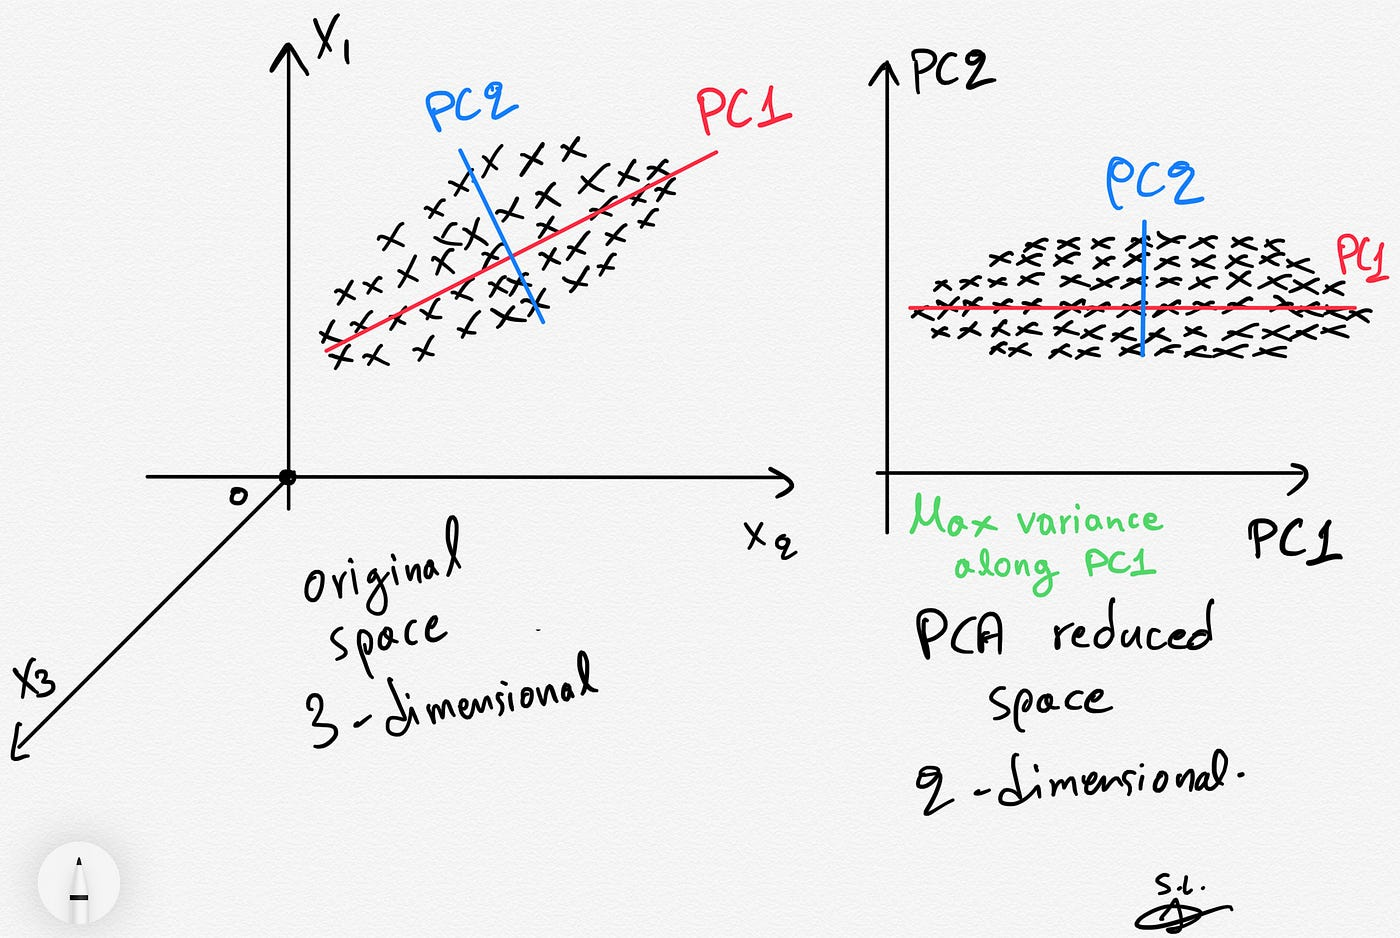

<h3>Análisis de Componentes Principales (PCA)</h3> <p>El objetivo del PCA es reducir la dimensionalidad de datos conservando la mayor información posible. El proceso se divide en las siguientes etapas:</p> <h4>1. Estandarización de datos</h4> <p>Antes de aplicar PCA, es común estandarizar los datos para que todas las variables tengan media cero y desviación estándar uno. Esto evita que las variables con escalas diferentes dominen el análisis.</p> <p>Si tenemos $p$ variables, la matriz de datos estandarizada $X$ se calcula de la siguiente manera:</p> 

$$X=\frac{(x_1-\mu_1)}{\sigma_1},\frac{(x_2-\mu_2)}{\sigma_2},...,\frac{(x_p-\mu_p)}{\sigma_p}$$

Donde $x_i$ es la columna $i$-ésima de la matriz original, $\mu_i$ es la media de la columna $i$-ésima, y $\sigma_i$la desviación estándar de la columna $i$-ésima.</p> <h4>
    
2. Cálculo de la matriz de covarianza</h4> <p>La matriz de covarianza $S$ de las variables estandarizadas se calcula de la siguiente manera:

$$S=\frac{1}{n−1}X^TX $$ 

Donde nn es el número de observaciones y $X^T$ es la matriz traspuesta de $X$.</p> 

<h4>3. Cálculo de vectores y valores propios</h4> <p>El siguiente paso es encontrar los vectores y valores propios de la matriz de covarianza $S$ resolviendo $$Sv=λv$$, donde $v$ es un vector propio, $\lambda$ es el valor propio correspondiente y SS es la matriz de covarianza.</p>

<h4>4. Selección de componentes principales</h4> <p>Los valores propios representan la cantidad de varianza explicada por cada componente principal. Por lo general, se ordenan en orden descendente. Los componentes principales se seleccionan en función de la cantidad de varianza que explican. Por ejemplo, si se desea retener el $95\%$ de la varianza total, se seleccionan los primeros $k$ componentes principales que suman al menos el $95\%$ de la varianza total.</p> 

<h4>5. Proyección de datos</h4> <p>Finalmente, los datos originales se proyectan en el espacio definido por los componentes principales seleccionados. La proyección de un punto de datos en un componente principal se calcula como el producto escalar entre el punto de datos y el vector propio del componente principal.</p> 
$$Y= X \cdot Y$$

<p>Donde $Y$ es la matriz de datos proyectados, $X$ es la matriz de datos estandarizados, y $V$ es la matriz de vectores propios correspondientes a los componentes principales seleccionados.</p>

<p>Esto reduce la dimensionalidad de los datos al espacio definido por los componentes principales, lo que permite una representación más compacta de los datos originales mientras se conserva la mayor cantidad de información posible. El PCA se utiliza ampliamente en estadísticas, análisis de datos y aprendizaje automático para reducir la complejidad de los datos y facilitar su análisis.</p>

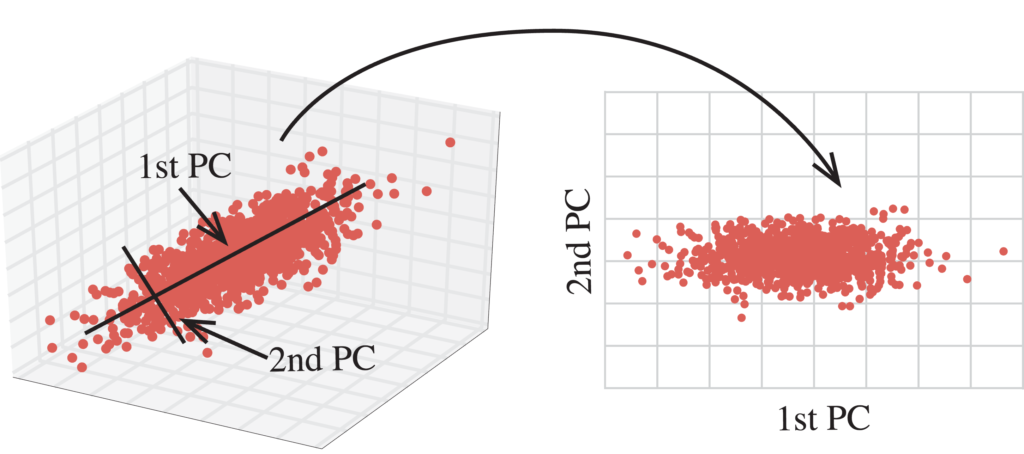

In [ ]:
from sklearn import decomposition 
pca = decomposition.PCA()
pca.n_components = 2
pca_df = pca.fit_transform(cluster) 
pca_df

<h4>Elección del número óptimo de clusters</h4> <p>Una parte importante del agrupamiento jerárquico es determinar el número apropiado de clusters (o grupos) en que dividir los datos. Existen diferentes criterios y métodos para seleccionar este número óptimo de clusters:</p> <h5>Método del codo:</h5> <p>Se grafica el valor de error dentro de los clusters (distancia intra-cluster) frente al número de clusters. El punto donde se produce un "codo" o cambio brusco en la curva indica el número óptimo de clusters.</p> <h5>Índice de silueta:</h5> <p>Mide cómo de bien asignados están los puntos a los clusters desde -1 a 1. El número de clusters con el valor promedio más alto suele ser óptimo.</p> <h5>Coeficiente de variación:</h5> <p>Indica qué parte de la variabilidad total es explicada por la partición en clusters. Cuanto menor sea el coeficiente de variación, mejor será la partición.</p> <p>Estos métodos ayudan a determinar automáticamente el número de grupos que mejor representan la estructura subyacente en los datos agrupados.

In [ ]:
from sklearn.cluster import KMeans 
wcss_list = [] 
for i in range(1,11):
    kmeans = KMeans(n_clusters=i,init = 'k-means++',random_state=42) 
    kmeans.fit(cluster) 
    wcss_list.append(kmeans.inertia_) 
plt.plot(range(1,11),wcss_list) 
plt.title('elbow method') 
plt.xlabel('No of clusters(k)') 
plt.ylabel('wcss') 
plt.show()


<h4>Disminución del wcss para k = 3</h4> <p>Existe una disminución del valor del wcss (within cluster sum of squares, suma de cuadrados intracluster) cuando k = 3.</p> <p>Por este motivo, elijo k = 3 como el número óptimo de clusters.</p>

<h3>Algoritmo K-Means</h3> <p>El algoritmo K-Means es un método de agrupamiento o clustering que se utiliza en aprendizaje automático y análisis de datos para dividir un conjunto de datos en grupos o clústeres, de manera que los puntos dentro de un mismo clúster sean más similares entre sí que con los puntos en otros clústeres. A continuación, te proporcionaré una explicación detallada de la teoría detrás del algoritmo K-Means:</p> <h4>Conceptos básicos:</h4> <h5>Clustering:</h5> <p>El clustering es una técnica de aprendizaje no supervisado que implica dividir un conjunto de datos en grupos o clústeres con características similares.</p> <h5>K-Means:</h5> <p>K-Means es un algoritmo de clustering que busca dividir los datos en K clústeres, donde K es un valor que se elige previamente. El objetivo principal del algoritmo K-Means es minimizar la suma de las distancias cuadradas entre los puntos de datos y el centroide de su clúster correspondiente.

<h3>Pasos del algoritmo K-Means</h3> <h4>Inicialización:</h4> <p>Se elige un valor para K, que representa el número de clústeres en los que se desea dividir el conjunto de datos.<br> Se seleccionan K puntos aleatorios del conjunto de datos como los centroides iniciales de los clústeres.</p> <h4>Asignación de puntos a clústeres:</h4> <p>Cada punto de datos se asigna al clúster cuyo centroide esté más cerca de él en términos de distancia euclidiana.</p> <h4>Actualización de centroides:</h4> <p>Se recalculan los centroides de cada clúster como el punto medio de todos los puntos asignados a ese clúster.</p> <h4>Repetición:</h4> <p>Se repiten los pasos 2 y 3 hasta que se cumpla un criterio de convergencia, como que los centroides ya no cambien significativamente o se alcance un número máximo de iteraciones.</p> <h4>Resultados:</h4> <p>Una vez que el algoritmo ha convergido, los puntos de datos se habrán dividido en K clústeres.</p><h4>Consideraciones y desafíos:</h4> <p>La elección de K, sensibilidad a la inicialización, suposiciones de clusters convexos e iguales, y sensibilidad a valores atípicos.</p> <p>K-Means es ampliamente utilizado en la exploración de datos y segmentación de clientes, entre otras aplicaciones. Es un algoritmo eficiente y relativamente fácil de implementar, pero requiere cierto conocimiento previo para elegir K y gestionar sus limitaciones.</p>

<h3>Distancia Euclidiana</h3> <p>La distancia entre dos puntos en un espacio n-dimensional se calcula utilizando la distancia euclidiana, que es la métrica más comúnmente utilizada en el algoritmo K-Means.</p> 

Dados dos puntos, $p$ y $q$, en un espacio n-dimensional, la distancia euclidiana se calcula como:

$$d(p,q) = \sum_{i=1}^{n}(p_i-q_i)^2$$

Donde:

$d(p,q)$ es la distancia entre los puntos $p$ y $q$.
 
$p_i$ y $q_i$ son las coordenadas de los puntos $p$ y $q$ en la dimensión $i$.

<h4>Centroide de un Clúster</h4>

El centroide de un clúster, denotado como $C_k$, se calcula como el punto medio de todos los puntos en ese clúster:

$$C_k = \frac{1}{n_k} \sum_{i=1}^{n_k} x_i$$

Donde: 

$C_k$ es el centroide del clúster $k$.

$n_k$ es el número de puntos en el clúster $k$.

$x_i$ son las coordenadas del punto $i$ en el clúster $k$.


<h4>Función de Costo</h4> 

En K-Means, el objetivo es minimizar la suma de las distancias al cuadrado entre cada punto y el centroide de su clúster. Esto se puede expresar como una función de costo $J$ de la siguiente manera:

$$J = \sum_{k=1}^{K} \sum_{i=1}^{n_k}||x_i-C_k||^2$$

El algoritmo K-Means busca iterativamente minimizar esta función de costo ajustando los centroides y reasignando puntos a clústeres hasta que converja a una solución estable.

In [ ]:
kmeans = KMeans(n_clusters=3,init = 'k-means++',random_state=42) 
y_pred = kmeans.fit_predict(cluster) 

In [ ]:
y_pred

In [ ]:
plt.figure(figsize=(15,10))
plt.scatter(pca_df[y_pred==0,0],pca_df[y_pred==0,1],s=100,c='skyblue',label = 'Cluster 1') 
plt.scatter(pca_df[y_pred==1,0],pca_df[y_pred==1,1],s=100,c='lightgreen',label = 'Cluster 2') 
plt.scatter(pca_df[y_pred==2,0],pca_df[y_pred==2,1],s=100,c='darkblue',label = 'Cluster 3') 
plt.scatter(pca_df[y_pred==3,0],pca_df[y_pred==3,1],s=100,c='maroon',label = 'Cluster 4') 
plt.scatter(pca_df[y_pred==4,0],pca_df[y_pred==4,1],s=100,c='cyan',label = 'Cluster 5') 
 
plt.title('Clusters of songs') 
plt.xlabel('Principal_Comp1') 
plt.ylabel('Principal_Comp2') 
plt.show()

In [ ]:
import seaborn as sns


# Crear un DataFrame con los datos
data = pd.DataFrame({'PC1': pca_df[:, 0], 'PC2': pca_df[:, 1], 'Cluster': y_pred})

# Define una paleta de colores personalizada
colores = ['skyblue', 'lightgreen', 'darkblue', 'maroon', 'cyan']

# Configura el estilo de Seaborn
sns.set(style="whitegrid")

# Crea el gráfico de dispersión utilizando Seaborn
plt.figure(figsize=(15, 10))
for i in range(5):
    sns.scatterplot(data=data[data['Cluster'] == i], x='PC1', y='PC2', s=100, color=colores[i], label=f'Cluster {i + 1}')

plt.title('Clusters of songs')
plt.xlabel('Principal_Comp1')
plt.ylabel('Principal_Comp2')
plt.legend(title='Cluster')
plt.show()


In [ ]:
cluster['label'] = y_pred 
cluster.head()

In [ ]:
from sklearn.metrics import silhouette_score
silhouette_score(cluster, cluster['label'], metric='euclidean')

<h4>El puntaje de silueta es mayor a 0.5</h4> <p>El puntaje de silueta obtenido es mayor a 0.5. Su valor se aleja de 0, lo que indica que el agrupamiento realizado es bastante bueno y no existen superposiciones significativas entre los clusters.</p> <p>Un puntaje de silueta mayor a 0.5 sugiere que los puntos están bien asignados a sus respectivos clusters, con poca ambigüedad. Valores cercanos a 1 indican una partición nítida de los datos, mientras que valores cercanos a 0 revelan clusters que se superponen.</p> <p>Por lo tanto, el alto puntaje de silueta en este caso confirma que el agrupamiento aplicado distribuyó claramente los datos en clusters bien diferenciados.</p>

In [ ]:
table = pd.pivot_table(cluster, index=['label'], aggfunc=np.mean) 
table 

<h3>Análisis de Clustering</h3> <h4>Cluster 0</h4> <p>Estas canciones son menos acústicas/instrumentales. Este cluster consiste en canciones que tienen mayor loudness, energía y tempo. Definitivamente es el cluster más dinámico. Tienen la valencia más alta. Estas canciones tienen las vibras más alegres.</p> <h4>Cluster 1</h4> <p>Este cluster contiene canciones que es más probable que hayan sido interpretadas en vivo, dado que los índices de liveness y speechiness son los más altos. Este cluster también tiene una alta acousticness.</p> <h4>Cluster 2</h4> <p>Estas canciones tienen la mayor acousticness e instrumentalness. Este cluster tiene el estilo musical más lento.</p>

<h3>Agrupamiento Jerárquico</h3> <p>Tomé una muestra aleatoria de 10.000 puntos de nuestro conjunto de datos. Luego, realicé un agrupamiento jerárquico sobre esta muestra.</p> <p>El agrupamiento jerárquico es un método de clustering que sigue un enfoque de "bottom-up": empieza considerando cada punto de datos como un cluster individual, y va agrupándolos iterativamente sobre la base de su similitud o distancia, formando nuevos clusters cada vez más grandes, hasta obtener un solo cluster que contenga a todos los puntos.</p> <p>Esta técnica no requiere especificar el número de clusters a priori, sino que los va definiendo de forma automática en base a los umbrales o distancias de fusión entre grupos.</p>

<h3>Agrupamiento Jerárquico (Hierarchical Clustering)</h3> <p>El agrupamiento jerárquico es un enfoque en análisis de datos y aprendizaje automático que se utiliza para agrupar objetos o puntos de datos en un conjunto de datos en una estructura jerárquica. Este método se basa en la idea de que los objetos similares se agrupan en subgrupos más grandes, lo que permite una representación jerárquica de la estructura de los datos.</p> <h4>Dendrograma</h4> <p>El resultado principal del agrupamiento jerárquico es un dendrograma. Un dendrograma es un árbol jerárquico que representa la estructura de agrupamiento de los datos.</p> <h4>Enlace entre grupos</h4> <p>El agrupamiento jerárquico se basa en la noción de distancia o similitud entre puntos de datos. Existen diferentes métodos de enlace que se utilizan para calcular la distancia o similitud entre grupos o puntos de datos.</p> <h4>Dos enfoques</h4> <p>El agrupamiento jerárquico se puede realizar de forma aglomerativa o divisiva.</p> <h4>Métricas de distancia</h4> <p>Para calcular la distancia o similitud entre puntos de datos, se utilizan diversas métricas.</p> <h4>Selección de grupos</h4> <p>Puedes seleccionar el número de grupos finales al cortar el dendrograma a una cierta altura.</p> <h4>Usos comunes</h4> <p>El agrupamiento jerárquico se utiliza en una variedad de aplicaciones.</p>

In [ ]:
cluster = cluster.drop(columns=['label'])
cluster_sample = cluster.sample(n=10000) 
cluster_sample.head() 

In [ ]:
cluster_sample.shape

In [ ]:
from sklearn import decomposition 
pca = decomposition.PCA()
pca.n_components = 2
pca_df = pca.fit_transform(cluster_sample) 
pca_df

In [ ]:
pca_df.shape

<h4>Elección de k=3 para el agrupamiento jerárquico</h4> <p>Para seleccionar el número óptimo de clusters (k) en el agrupamiento jerárquico realizado sobre la muestra de datos, revisé diferentes métodos:</p> <ul> <li>Método del codo: No se observó un cambio brusco en la curva, por lo que no fue concluyente.</li> <li>Índice de silueta: El valor promedio fue mayor para k=3, lo que sugiere esta partición.</li> <li>Coeficiente de variación: Fue menor para k=3, indicando que explica mejor la variabilidad de los datos.</li> </ul> <p>Considerando los diferentes criterios, seleccioné k=3 como el número óptimo de clusters que representa mejor la estructura subyacente en los datos agrupados de forma jerárquica.</p>

In [ ]:
from sklearn.cluster import AgglomerativeClustering
hc = AgglomerativeClustering(n_clusters=3, affinity= 'euclidean',linkage='ward') 
y_pred = hc.fit_predict(cluster_sample)

In [ ]:
plt.figure(figsize=(15,10))
plt.scatter(pca_df[y_pred==0,0],pca_df[y_pred==0,1],s=100,c='blue',label = 'Cluster 1') 
plt.scatter(pca_df[y_pred==1,0],pca_df[y_pred==1,1],s=100,c='green',label = 'Cluster 2') 
plt.scatter(pca_df[y_pred==2,0],pca_df[y_pred==2,1],s=100,c='red',label = 'Cluster 3') 
plt.scatter(pca_df[y_pred==3,0],pca_df[y_pred==3,1],s=100,c='maroon',label = 'Cluster 4') 
plt.scatter(pca_df[y_pred==4,0],pca_df[y_pred==4,1],s=100,c='cyan',label = 'Cluster 5') 

plt.title('Clusters of songs') 
plt.xlabel('Principal_Comp1') 
plt.ylabel('Principal_Comp2') 
plt.show()

In [ ]:
cluster_sample['Label']=y_pred

In [ ]:
from sklearn.metrics import silhouette_score
silhouette_score(cluster_sample, cluster_sample['Label'], metric='euclidean')

<h4>El puntaje de silueta es mayor a 0.5</h4> <p>El puntaje de silueta que hemos obtenido del agrupamiento jerárquico es mayor a 0.5. Este valor se aleja de 0, lo que indica que el clustering realizado es bastante bueno y no existen superposiciones significativas entre los grupos o clusters.</p> <p>Un puntaje de silueta mayor a 0.5 sugiere que los puntos de datos están bien asignados a sus respectivos grupos o clusters, con poca ambigüedad. Valores cercanos a 1 indican una partición nítida de los datos, mientras que valores cercanos a 0 revelan grupos que se superponen.</p> <p>Por lo tanto, el alto puntaje de silueta en este caso confirma que el agrupamiento jerárquico aplicado distribuyó claramente los datos en clusters bien diferenciados, sin solapamientos importantes entre ellos.</p>

In [ ]:
table = pd.pivot_table(cluster_sample, index=['Label'], aggfunc=np.mean) 
table

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage
# Calcular el dendrograma
linked = linkage(cluster_sample, method='ward')  # Método de enlace: ward

# Crear el gráfico del dendrograma
plt.figure(figsize=(10, 6))
sns.set(style='whitegrid')
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.title('Dendrograma')
plt.xlabel('Índices de datos')
plt.ylabel('Distancia')
plt.show()

In [ ]:
# Calcular el dendrograma
linked = linkage(cluster_sample, method='single')  # Método de enlace: ward

# Crear el gráfico del dendrograma
plt.figure(figsize=(10, 6))
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.title('Dendrograma')
plt.xlabel('Índices de datos')
plt.ylabel('Distancia')
plt.show()

In [ ]:
# Calcular el dendrograma
linked = linkage(cluster_sample, method='complete')  # Método de enlace: ward

# Crear el gráfico del dendrograma
plt.figure(figsize=(10, 6))
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.title('Dendrograma')
plt.xlabel('Índices de datos')
plt.ylabel('Distancia')
plt.show()

In [ ]:
# Calcular el dendrograma
linked = linkage(cluster_sample, method= 'centroid')  # Método de enlace: ward

# Crear el gráfico del dendrograma
plt.figure(figsize=(10, 6))
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.title('Dendrograma')
plt.xlabel('Índices de datos')
plt.ylabel('Distancia')
plt.show()

In [ ]:
# Calcular el dendrograma
linked = linkage(cluster_sample, method='average')  # Método de enlace: ward

# Crear el gráfico del dendrograma
plt.figure(figsize=(10, 6))
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.title('Dendrograma')
plt.xlabel('Índices de datos')
plt.ylabel('Distancia')
plt.show()

In [ ]:
linked = linkage(cluster_sample, method='ward')  # Método de enlace: ward

# Crear el gráfico del dendrograma utilizando Seaborn
plt.figure(figsize=(10, 6))
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True, no_labels=True)

# Configurar el estilo de Seaborn
sns.set(style='whitegrid')

plt.title('Dendrograma')
plt.xlabel('Índices de datos')
plt.ylabel('Distancia')
plt.show()